## Fashion MNIST Classification 문제

### 텐서플로와 다른 라이브러리 임포트

In [ ]:
# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


In [ ]:
# 런타임에서 할당하는데 필요한 양만큼의 GPU 메모리를 할당
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

### 패션 MNIST 데이터셋 임포트하기

load_data() 함수를 호출해서 Fashion MNIST 로딩 : 네 개의 넘파이(NumPy) 배열이 반환

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 데이터 탐색

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
len(train_labels)

60000

In [ ]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [ ]:
test_images.shape

(10000, 28, 28)

In [ ]:
len(test_labels)

10000

### 데이터 전처리

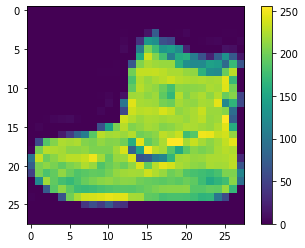

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

픽셀 값을 [0,255]에서 [0,1]로 조정

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Traning Set 25개 이미지, 클래스 이름 출력

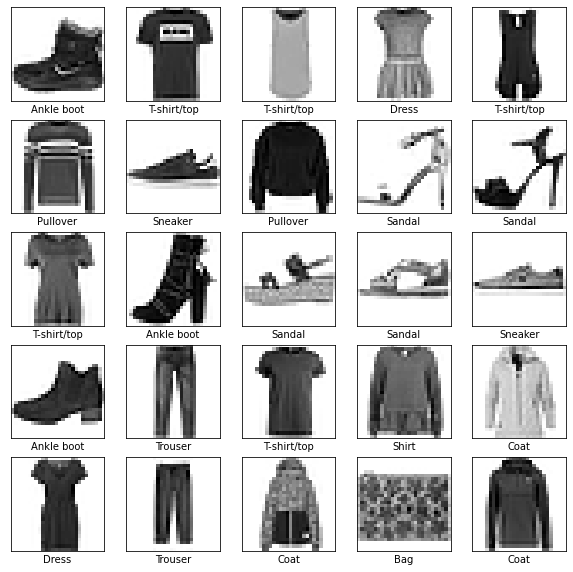

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### 모델 구성

In [ ]:
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time) => 28*28 이미지를 한 row씩 28 time step으로 만들어 줄 것이다.
# 즉, 첫번째 layer에서는 1*28인 vector형태가 들어간다
time_step = 28
input_dim = 28
units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model (tf.keras.layers.LSTM) => RNN으로 LSTM 사용함 / cell의 뉴런 개수는 64개 사용
# tf.keras.layers.LSTM은 input batch size와 time step, input dimension을 고려해야한다
# keras.layers.LSTM의 옵션 return_sequence에서 True이면 모든 step의 출력이 나와 many-to-many로 출력이 (batch size, time step, output dimension)으로 나온다 / False이면 many-to-one으로 (batch size, output dimension)출력
# Batch Normalization 적용
def build_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(units, input_shape=(time_step,input_dim)), #첫번째 계층의 뉴런은 64개, input shape은 (time step, input dimension)으로 28,28로 들어가야한다
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(output_size, activation='softmax') # 분류 문제이기 때문에 softmax함수 사용, output_size는 label수가 10개
  ])
  return model

In [ ]:
model = build_model()

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

### 모델 훈련

In [ ]:
batch_size = 64
model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=5)

Epoch 1/5
938/938 [==============================] - 4s 4ms/step - loss: 0.5844 - accuracy: 0.7900
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.4163 - accuracy: 0.8504
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.3762 - accuracy: 0.8634
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.3495 - accuracy: 0.8729
Epoch 5/5
938/938 [==============================] - 4s 5ms/step - loss: 0.3338 - accuracy: 0.8766


### 테스트 성능 측정 (정확도)

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\n테스트 정확도:', test_acc)

313/313 - 1s - loss: 0.3567 - accuracy: 0.8687

테스트 정확도: 0.8687000274658203


### 예측 만들기

In [ ]:
predictions = model.predict(test_images)

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

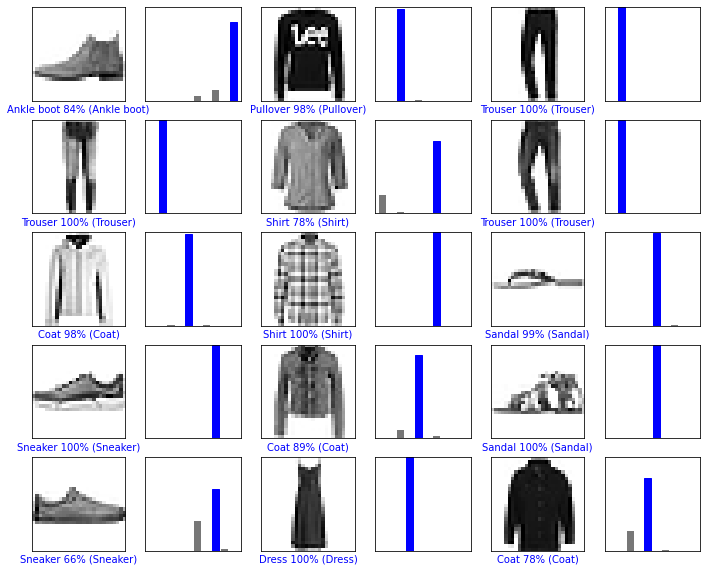

In [ ]:
# 처음 X 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력합니다
# 올바른 예측은 파랑색으로 잘못된 예측은 빨강색으로 나타냅니다
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()